In [1]:
import pandas as pd
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('product_review_dataset.csv')

In [3]:
dataset_for_knn = dataset.drop(['Unnamed: 0'], axis=1)

In [4]:
# Removing all users who have not provided more than 1 rating
filtered_df = dataset_for_knn.groupby('userId').filter(lambda x : len(x) > 1)
n_users = filtered_df.nunique()[0]
n_items = filtered_df.nunique()[1]
print(filtered_df.nunique())

userId       71894
productId     5198
rating           4
dtype: int64


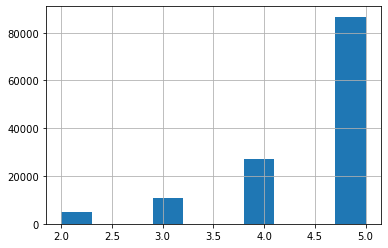

In [5]:
filtered_df = filtered_df.drop(filtered_df.query('rating == 5').sample(frac=0.4).index)
filtered_df['rating'].hist()

In [6]:
filtered_df.shape

(129909, 3)

In [18]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ml_metrics
from sklearn.metrics import accuracy_score
import numpy as np

In [8]:
def top_ten_predicted(model, user, items):
    predictions = model.predict([np.array([user]*len(items)), items])
    predictions_df = pd.DataFrame(predictions, columns=['ratings'])
    item_id_df = pd.DataFrame(item_encoding, columns = ['itemId'])
    item_id_df['ratings'] = predictions_df['ratings']
    top_10 = item_id_df.sort_values(by = ['ratings'], ascending=False)[:10]
    return top_10['itemId'].values

In [9]:
def top_ten_actual(df, user):
    return df[df['userId'] == user].sort_values(by = ['rating'], ascending=False)[:100]['productId'].values

In [10]:
user_enc = LabelEncoder()
filtered_df['userId'] = user_enc.fit_transform(filtered_df['userId'].values)

In [11]:
item_enc = LabelEncoder()
filtered_df['productId'] = item_enc.fit_transform(filtered_df['productId'].values)

In [12]:
item_encoding = filtered_df['productId'].unique()

In [13]:
user_encoding = filtered_df['userId'].unique()

In [14]:
item_encoding

array([   0,    1,    2, ..., 4900, 4896, 4897])

In [15]:
user_encoding

array([28843, 21466, 33611, ..., 16367, 59907, 53431])

In [19]:
X = np.array([filtered_df['userId'], filtered_df['productId']]).T
y = np.array(filtered_df['rating']).T

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116918, 2), (12991, 2), (116918,), (12991,))

In [23]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [24]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def Recommender(n_users, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    item = Input(shape=(1,))
    i = EmbeddingLayer(n_items, n_factors)(item)
    ib = EmbeddingLayer(n_items, 1)(item)
    x = Dot(axes=1)([u, i])
    x = Add()([x, ub, ib])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [25]:
model = Recommender(n_users, n_items, 50, 1, 5)
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 35s 19ms/step - loss: 1.6549 - val_loss: 0.9099
Epoch 2/20
1827/1827 [==============================] - 35s 19ms/step - loss: 0.5199 - val_loss: 0.8855
Epoch 3/20
1827/1827 [==============================] - 36s 20ms/step - loss: 0.5021 - val_loss: 0.8153
Epoch 4/20
1827/1827 [==============================] - 37s 20ms/step - loss: 0.4801 - val_loss: 0.8204
Epoch 5/20
1827/1827 [==============================] - 37s 20ms/step - loss: 0.4857 - val_loss: 0.8021
Epoch 6/20
1827/1827 [==============================] - 37s 20ms/step - loss: 0.4791 - val_loss: 0.7934
Epoch 7/20
1827/1827 [==============================] - 37s 20ms/step - loss: 0.4654 - val_loss: 0.7748
Epoch 8/20
1827/1827 [==============================] - 37s 20ms/step - loss: 0.4548 - val_loss: 0.7698
Epoch 9/20
1827/1827 [==============================] - 36s 20ms/step - loss: 0.4459 - val_loss: 0.7705
Epoch 10/20
1827/1827 [==============================] - 35s 19m

In [26]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.6576091140020014

In [27]:
top_ten_predicted(model, 3, item_encoding)

array([3156, 2517, 2179, 4025, 2180, 3670, 3155, 2319, 1067, 2481])

In [28]:
model.save('first_model')

INFO:tensorflow:Assets written to: first_model/assets
